### Import Libraries

In [4]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn
import utils # Importe o utils.py do repositório mdeff/fma

### Audio Preprocessing

In [5]:
# 1. Carregar os dados oficiais
# Certifique-se de que o utils.py do mdeff/fma esteja no seu diretório
METADATA_DIR = '../fma_metadata' 
tracks = utils.load(f'{METADATA_DIR}/tracks.csv')
features = utils.load(f'{METADATA_DIR}/features.csv')

# 2. Filtrar pelo dataset 'small'
small_mask = tracks[('set', 'subset')] == 'small'

X_all = features.loc[small_mask]
y_all_labels = tracks.loc[small_mask, ('track', 'genre_top')]
splits = tracks.loc[small_mask, ('set', 'split')]

print(f"Total de faixas 'fma_small': {X_all.shape[0]}")
print(f"Total de features: {X_all.shape[1]}")

# 3. Codificar os Gêneros (Labels)
label_encoder = LabelEncoder()
y_all_encoded = label_encoder.fit_transform(y_all_labels)

# 4. Separar em Treino, Validação e Teste (usando os splits oficiais)
X_train = X_all[splits == 'training']
y_train = y_all_encoded[splits == 'training']

X_val = X_all[splits == 'validation']
y_val = y_all_encoded[splits == 'validation']

X_test = X_all[splits == 'test']
y_test = y_all_encoded[splits == 'test']

print(f"Amostras de Treino: {X_train.shape[0]}")
print(f"Amostras de Validação: {X_val.shape[0]}")
print(f"Amostras de Teste: {X_test.shape[0]}")

# 5. Normalizar as Features
scaler = StandardScaler()

# Ajustar (fit) APENAS nos dados de treino
scaler.fit(X_train)

# Transformar todos os conjuntos
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Total de faixas 'fma_small': 8000
Total de features: 518
Amostras de Treino: 6400
Amostras de Validação: 800
Amostras de Teste: 800


### Treino dos Modelos


=== Treinando KNN (k=1) ===
--- Avaliando KNN (k=1) ---
Acurácia KNN (k=1) (por janela): 35.00%

Relatório de Classificação KNN (k=1):
               precision    recall  f1-score   support

   Electronic       0.62      0.20      0.30       100
 Experimental       0.70      0.07      0.13       100
         Folk       0.19      0.26      0.22       100
      Hip-Hop       0.48      0.74      0.58       100
 Instrumental       0.35      0.09      0.14       100
International       0.22      0.61      0.32       100
          Pop       0.41      0.16      0.23       100
         Rock       0.56      0.67      0.61       100

     accuracy                           0.35       800
    macro avg       0.44      0.35      0.32       800
 weighted avg       0.44      0.35      0.32       800


Matriz de Confusão:


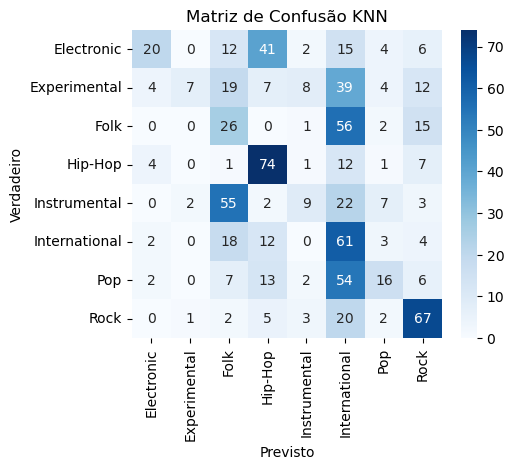


=== Treinando Random Forest ===
--- Avaliando Random Forest ---
Acurácia Random Forest (por janela): 47.50%

Relatório de Classificação Random Forest:
               precision    recall  f1-score   support

   Electronic       0.53      0.55      0.54       100
 Experimental       0.33      0.28      0.30       100
         Folk       0.24      0.28      0.26       100
      Hip-Hop       0.55      0.69      0.61       100
 Instrumental       0.46      0.42      0.44       100
International       0.51      0.49      0.50       100
          Pop       0.51      0.39      0.44       100
         Rock       0.67      0.70      0.69       100

     accuracy                           0.47       800
    macro avg       0.47      0.47      0.47       800
 weighted avg       0.47      0.47      0.47       800


Matriz de Confusão:


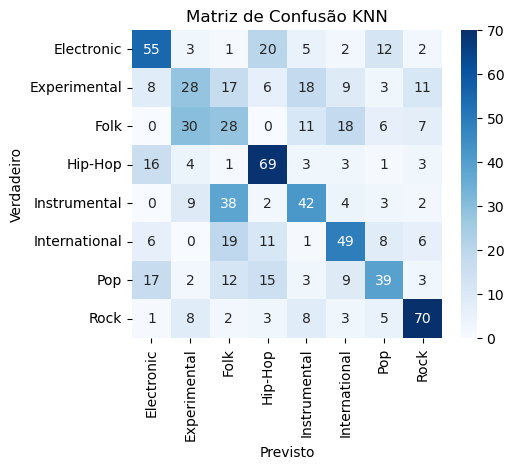


=== Treinando SVM (Linear) ===
--- Avaliando SVM (Linear) ---
Acurácia SVM (Linear) (por janela): 47.88%

Relatório de Classificação SVM (Linear):
               precision    recall  f1-score   support

   Electronic       0.58      0.60      0.59       100
 Experimental       0.36      0.43      0.39       100
         Folk       0.25      0.25      0.25       100
      Hip-Hop       0.68      0.72      0.70       100
 Instrumental       0.41      0.38      0.39       100
International       0.58      0.41      0.48       100
          Pop       0.42      0.41      0.41       100
         Rock       0.59      0.63      0.61       100

     accuracy                           0.48       800
    macro avg       0.48      0.48      0.48       800
 weighted avg       0.48      0.48      0.48       800


Matriz de Confusão:


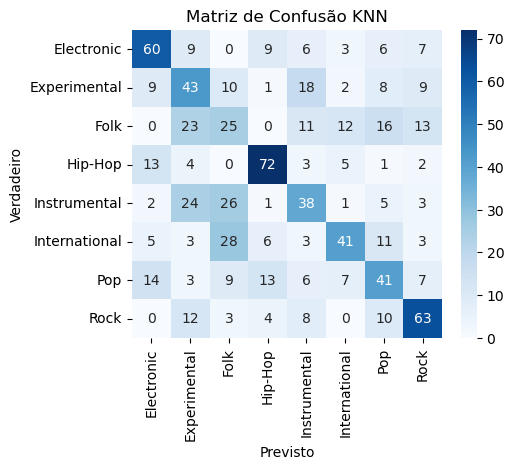

In [6]:
# --- Dicionário de Modelos ---
models = {
    "KNN (k=1)": KNeighborsClassifier(n_neighbors=85, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=1000, max_depth=10, criterion="gini", n_jobs=-1),
    #"SVM (Linear)": SVC(kernel='rbf', C=0.17, tol=0.001)
    "SVM (Linear)": SVC(decision_function_shape="ovo")
}

# --- Treinar e Avaliar ---
for name, model in models.items():
    print(f"\n=== Treinando {name} ===")
    model.fit(X_train_scaled, y_train)
    
    print(f"--- Avaliando {name} ---")
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Acurácia {name} (por janela): {accuracy * 100:.2f}%\n")
    
    print(f"Relatório de Classificação {name}:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Matriz de Confusão
    print("\nMatriz de Confusão:")
    c_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    seaborn.heatmap(c_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.title('Matriz de Confusão KNN')
    plt.show()